In [1]:
%matplotlib inline
#! switch_R 3.3
%load_ext rpy2.ipython

In [2]:
import math
import numpy as np
import pandas as pd
import pickle
import pygam
from pyspan.config import *
from pyspan.ratings_task.analysis import freq_df, n_utterances, SparseLR
from pyspan.utils import *

/Users/sabinasloman/git/talking-politics/pyspan/config.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_i

In [3]:
signals = pickle.load(open(paths["metrics_dir"] + "signals-unigrams"))
words = pd.read_csv("{}synonyms.csv".format(paths["synonyms_task_path"]))
words = words.loc[range(7) + range(8,26)][["D","R"]]
words = np.ravel(words)
signals = dict(zip(words, 
                   map(lambda w: signals.loc[w]["rmetric"], words)))
valence_data = pd.read_csv("valence_data.csv")
valences = dict(zip(np.ravel(valence_data[["D","R"]]), 
                    np.ravel(valence_data[["D_valence","R_valence"]]))
               )

In [4]:
df = pd.read_csv("responses.csv")
df.rename(columns = { "1": 1, "2": 2, "3": 3, "4": 4, "5": 5 },
          inplace = True)
df.replace({ "1": 1, "2": 2, "3": 3, "4": 4, "5": 5 }, inplace = True)

In [5]:
list_party_cols = map(lambda i: "list{}_party".format(i), range(1,6))
list_cols = map(lambda i: "list{}".format(i), range(1,6))

# Participants

In [6]:
# Some demographics
# Mean age and standard error
print np.mean(df.age[~np.isnan(df.age)]), stats.sem(df.age[~np.isnan(df.age)])
# n identifying as male/female
print len(df.loc[df.gender == 2]), len(df.loc[df.gender == 1])
voted = df.voted.values
voted[voted == 2] = 0
# % voted
print np.mean(voted)

35.811764705882354 0.8264673367019187
102 66
0.788235294117647


# Results

In [7]:
dmask = np.ma.masked_where(df[list_party_cols] == "democrat", 
                           df[range(1,6)])
ddat = dmask.data[dmask.mask]
rmask = np.ma.masked_where(df[list_party_cols] == "republican", 
                           df[range(1,6)])
rdat = rmask.data[rmask.mask]

Mean participant rating on the Republican and Democratic items.

In [8]:
rmu = np.mean(rdat[~np.isnan(rdat)])
dmu = np.mean(ddat[~np.isnan(ddat)])
rmu, dmu

(3.9569377990430623, 3.5416666666666665)

In [9]:
ddat_ = dmask.data.copy().astype("float")
ddat_[~dmask.mask] = np.nan
rdat_ = rmask.data.copy().astype("float")
rdat_[~rmask.mask] = np.nan
assert ddat_.shape == rdat_.shape

In [10]:
n, k = ddat_.shape

In [11]:
ixn = np.repeat(np.arange(n), k)

Perform one- and two-sample $t$-tests, using the clustered standard errors function provided by Arai (2011).

In [12]:
%%R
source("../clmclx.R")

One-sample test (judgments of the Democratic words). This tests the hypothesis that the mean is *greater* than or equal to the indifference point. Our hypothesis is that the mean is less than or equal to the indifference point, so the $p$-value reported in the paper is 1 - the $p$-value shown here.

In [13]:
%%R -i ddat_,ixn
yd <- c(t(ddat_)) - 3.5
ixnd <- ixn[which(!is.na(yd))]
fit <- lm(yd ~ 1)
print(fit$df.residual)
res <- clx(fit, 1, ixnd)
se <- res[1,2]
t <- res[1,3]
p <- res[1,4] / 2
print(paste(se, t, p))

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: zoo

  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘zoo’


  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


  warnings.warn(x, RRuntimeWarning)


[1] 431
[1] "0.062644319064084 0.665130809771313 0.253161290177374"


One-sample test (judgments of the Republican words).

In [14]:
%%R -i rdat_
yr <- c(t(rdat_)) - 3.5
ixnr <- ixn[which(!is.na(yr))]
fit <- lm(yr ~ 1)
print(fit$df.residual)
res <- clx(fit, 1, ixnr)
se <- res[1,2]
t <- res[1,3]
p <- res[1,4] / 2
print(paste(se, t, p))

[1] 417
[1] "0.0657689920344988 6.94761748520301 7.17869373919611e-12"


Two-sample test (testing the difference in means).

In [15]:
groups = np.isnan(ddat_)

In [16]:
dat_ = ddat_.copy()
dat_[groups] = rdat_[groups]

In [17]:
%%R -i dat_,groups
y <- c(t(dat_)) - 3.5
x <- as.integer(c(t(groups)))
ixn_ <- ixn[which(!is.na(y))]
fit <- lm(y ~ x)
print(fit$df.residual)
res <- clx(fit, 1, ixn_)
se <- res[2,2]
t <- res[2,3]
p <- res[2,4] / 2
print(paste(se, t, p))

[1] 848
[1] "0.0920699146428025 4.51038902324924 3.69102129251564e-06"


## Effect size

Using the formula from [Rouder et al. (2012)](http://pcl.missouri.edu/sites/default/files/Rouder.JMP_.2012.pdf) and explained in [Jake Westfall's blog post](http://jakewestfall.org/blog/index.php/2016/03/25/five-different-cohens-d-statistics-for-within-subject-designs/).

In [18]:
%%R
library("lme4")
mod <- lmer(y ~ x + (x|ixn))
delta <- summary(mod)$coefficients[2,1]
sig <- sigma(mod)
delta / sig

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: boundary (singular) fit: see ?isSingular

  warnings.warn(x, RRuntimeWarning)


[1] 0.2960532


## Participant-level analyses

In [19]:
acc_dat = dat_.copy()
acc_dat[groups] = acc_dat[groups] > 3.5
acc_dat[~groups] = acc_dat[~groups] < 3.5
paccs = np.mean(acc_dat, axis=1)

In [20]:
np.mean(paccs), stats.sem(paccs)

(0.5717647058823528, 0.015769474215354358)

In [21]:
t, p = stats.ttest_1samp(paccs, .5)
t, p / 2, len(paccs) - 1, len(paccs[paccs > .5])

(4.550862311723575, 5.085073814931977e-06, 169, 110)

Restricting to Republican items.

In [22]:
def mean_(a):
    return np.mean(a[~np.isnan(a)])

In [23]:
racc_dat = acc_dat.copy()
racc_dat[~groups] = np.nan
paccs_r = np.apply_along_axis(mean_, 1, racc_dat)
np.mean(paccs_r), stats.sem(paccs_r)

(0.6470588235294118, 0.021891080768245544)

Restricting to Democratic items.

In [24]:
dacc_dat = acc_dat.copy()
dacc_dat[groups] = np.nan
paccs_d = np.apply_along_axis(mean_, 1, dacc_dat)
np.mean(paccs_d), stats.sem(paccs_d)

(0.49803921568627446, 0.021676469945413678)

# Appendix D

A logistic regression where the unit of observation is the likelihood judgment of a group of five words. In particular, we will estimate the model, including participant-level effects:

REPUBLICAN ~ Sum(log odds that each word was spoken by a Republican) + Sum(valence of words) + Participant's party identity + Sum(valence of words) * Participant's party identity

where "REPUBLICAN" corresponds to a rating >= 3, or a judgment that the list of words was "more likely to have been spoken by a Republican".

In [25]:
lr_data = df.copy()
lr_data = lr_data.loc[lr_data.party.isin([ 1,2 ])]

n = len(lr_data)
# Add dummy columns
for i in range(1, n):
    ids = np.zeros(n)
    ids[i] = 1
    lr_data["participant{}".format(i)] = ids

In [26]:
Y_full = np.ravel(lr_data[range(1,6)])
Y = Y_full > 2.5
# (n ps * n choices, 4 + (n ps - 1) + n words)
X = np.full((n * 5, 4 + n - 1 + len(words)), np.nan)
# Sum(log odds that each word was spoken by a Republican)
vf = np.vectorize(lambda l: sum(map(lambda w: signals[w], 
                                    l.split(", "))))
X[:,0] = vf(np.ravel(lr_data[list_cols]))
# Sum(valence of words)
vf = np.vectorize(lambda l: sum(map(lambda w: valences[w] - 5, 
                                    l.split(", "))))
X[:,1] = vf(np.ravel(lr_data[list_cols]))
# Participant's political identity
vf = np.vectorize(lambda pid: int(pid == 1))
pids = np.repeat(vf(lr_data.party), 5)
pids[pids == 0] = -1
X[:,2] = pids
# Valence of word * Participant's party identity
X[:,3] = X[:,1] * X[:,2]

# Participant dummies
for i in range(4, 4 + n - 1):
    X[:,i] = np.repeat(lr_data["participant{}".format(i-3)], 5)
    
# Indicators of whether a particular word was in the set
for i in range(len(words)):
    vf = np.vectorize(lambda l: int(words[i] in l.split(", ")))
    X[:,4+n-1+i] = vf(np.ravel(lr_data[list_cols]))

In [27]:
Y = Y[~np.isnan(Y_full)]
X = X[~np.isnan(Y_full)]
Y_full = Y_full[~np.isnan(Y_full)]
X = X[~np.isnan(Y)]
Y_full = Y_full[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]
Y = Y[~np.isnan(X).any(axis = 1)]
Y_full = Y_full[~np.isnan(X).any(axis = 1)]
X = X[~np.isnan(X).any(axis = 1),:]

In [28]:
# Get a dataframe where the signal indicator is binarized
X_binary = X.copy()
X_binary[:,0] = [ x > 0 for x in X_binary[:,0] ]

Table 2 column 1: Binary DV; binary $logodds_R$ measure.

In [29]:
# Ensure the matrix is of full rank
assert X_binary[:,:4+n-1].shape[1] == np.linalg.matrix_rank(X_binary[:,:4+n-1])
logit = SparseLR(Y, X_binary[:,:4+n-1]); logit.coef[:4], logit.auc

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


(array([ 0.77131452, -0.07204687, -0.09881942,  0.05852519]),
 0.8157231452923424)

In [30]:
# Test using word indicators, for robustness
logit = SparseLR(Y, X_binary); logit.coef[:4]

array([0.0564404 , 0.00899905, 0.        , 0.03209182])

Table 2 column 2: Binary DV; continuous $logodds_R$ measure.

In [31]:
# Ensure the matrix is of full rank
assert X[:,:4+n-1].shape[1] == np.linalg.matrix_rank(X[:,:4+n-1])
logit = SparseLR(Y, X[:,:4+n-1]); logit.coef[:4], logit.auc

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(array([ 0.17634678, -0.06191901, -0.10158312,  0.05907993]),
 0.8142141743773423)

In [32]:
# Test using word indicators, for robustness
logit = SparseLR(Y, X); logit.coef[:4], logit.auc

(array([0.07142957, 0.00047752, 0.        , 0.03124853]), 0.6174012536066062)

Logistic GAM

In [33]:
X_ = X[:,:4+n-1]
logistic_gam = pygam.LogisticGAM(pygam.terms.TermList(*[pygam.s(0), pygam.s(1), 
                                 pygam.f(2), pygam.s(3)] + 
                                 [pygam.f(i) for i in range(4, X_.shape[1])]))
logistic_gam.fit(X_, Y)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + f(26) + f(27) + f(28) + f(29) + f(30) + f(31) + f(32) + f(33) + f(34) + f(35) + f(36) + f(37) + f(38) + f(39) + f(40) + f(41) + f(42) + f(43) + f(44) + f(45) + f(46) + f(47) + f(48) + f(49) + f(50) + f(51) + f(52) + f(53) + f(54) + f(55) + f(56) + f(57) + f(58) + f(59) + f(60) + f(61) + f(62) + f(63) + f(64) + f(65) + f(66) + f(67) + f(68) + f(69) + f(70) + f(71) + f(72) + f(73) + f(74) + f(75) + f(76) + f(77) + f(78) + f(79) + f(80) + f(81) + f(82) + f(83) + f(84) + f(85) + f(86) + f(87) + f(88) + f(89) + f(90) + f(91) + f(92) + f(93) + f(94) + f(95) + f(96) + f(97) + f(98) + f(99) + f(100) + f(101) + f(102) + f(103) + f(104) + f(105) + f(106) + f(107) + f(108) + f(109) + f(110) + f(111)

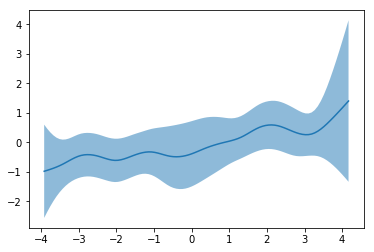

In [34]:
plot_prf(logistic_gam, 0, logit.coef[0])

Table 2 column 3: Ordinal DV; binary $logodds_R$ measure.

In [35]:
X_ = X_binary[:,:4+n-1]
lm = sm.OLS(Y_full, sm.add_constant(X_))
res = lm.fit()
res.params[1:5]

array([ 0.61403412, -0.05757925, -0.10674722,  0.03030968])

In [36]:
# Adjusted R squared
# https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2
ssr = ( (Y_full - res.predict(sm.add_constant(X_)))**2 ).sum()
ssr /= X_.shape[0] - X_.shape[1] - 1
sst = np.var(Y_full)*len(Y_full)
sst /= len(Y_full) - 1
1 - ssr / sst

0.020082739404998273

In [37]:
# Item-level indicators
lm = sm.OLS(Y_full, sm.add_constant(X_binary))
res = lm.fit()
res.params[1:5]

array([0.86885495, 0.01452983, 0.02907353, 0.02732486])

Table 2 column 4: Ordinal DV; continuous $logodds_R$ measure.

In [38]:
X_ = X[:,:4+n-1]
lm = sm.OLS(Y_full, sm.add_constant(X_))
res = lm.fit_regularized()
res.params[1:5]

array([ 0.14440349, -0.05011474, -0.09196279,  0.03028965])

In [39]:
# Adjusted R squared
# https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2
ssr = ( (Y_full - res.predict(sm.add_constant(X_)))**2 ).sum()
ssr /= X_.shape[0] - X_.shape[1] - 1
sst = np.var(Y_full)*len(Y_full)
sst /= len(Y_full) - 1
1 - ssr / sst

0.023209929281831077

In [40]:
# Item-level indicators
lm = sm.OLS(Y_full, sm.add_constant(X))
res = lm.fit_regularized()
res.params[1:5]

array([ 0.1006748 , -0.02557789,  0.01113508,  0.02732426])

Linear GAM

In [41]:
X_ = X[:,:4+n-1]
linear_gam = pygam.LinearGAM(pygam.terms.TermList(*[pygam.s(0), 
                             pygam.s(1), pygam.f(2), pygam.s(3)] + 
                             [pygam.f(i) for i in range(4, X_.shape[1])]))
linear_gam.fit(X_, Y_full)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + f(26) + f(27) + f(28) + f(29) + f(30) + f(31) + f(32) + f(33) + f(34) + f(35) + f(36) + f(37) + f(38) + f(39) + f(40) + f(41) + f(42) + f(43) + f(44) + f(45) + f(46) + f(47) + f(48) + f(49) + f(50) + f(51) + f(52) + f(53) + f(54) + f(55) + f(56) + f(57) + f(58) + f(59) + f(60) + f(61) + f(62) + f(63) + f(64) + f(65) + f(66) + f(67) + f(68) + f(69) + f(70) + f(71) + f(72) + f(73) + f(74) + f(75) + f(76) + f(77) + f(78) + f(79) + f(80) + f(81) + f(82) + f(83) + f(84) + f(85) + f(86) + f(87) + f(88) + f(89) + f(90) + f(91) + f(92) + f(93) + f(94) + f(95) + f(96) + f(97) + f(98) + f(99) + f(100) + f(101) + f(102) + f(103) + f(104) + f(105) + f(106) + f(107) + f(108) + f(109) + f(110) + f(111) +

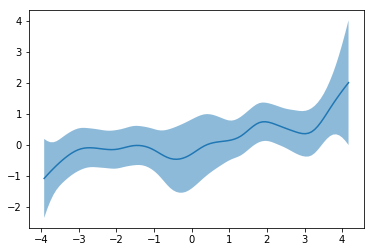

In [42]:
plot_prf(linear_gam, 0, res.params[1])

# Appendix E

$accurate \sim logodds + log(P) + party\_id + valence + party\_id \times valence \times sign(word) + party\_identity + party\_id \times party\_identity + political\_engagement + party\_id \times political\_engagement + \ldots{}$

In [43]:
lr_data = df.copy()
lr_data = lr_data.loc[lr_data.party.isin([ 1,2 ])]

n = len(lr_data)
# Add dummy columns
for i in range(1, n):
    ids = np.zeros(n)
    ids[i] = 1
    lr_data["participant{}".format(i)] = ids

n_vars = 9
    
Y_full = np.ravel(lr_data[range(1,6)])
Y = Y_full > 2.5
X = np.full((n * 5, n_vars + n - 1 + len(words)), np.nan)
# Sum(log odds that each word was spoken by a Republican)
vf = np.vectorize(lambda l: sum(map(lambda w: signals[w], 
                                    l.split(", "))))
s = vf(np.ravel(lr_data[list_cols]))
X[:,0] = np.abs(s)
# Sum(log(P) of each word)
calc_mP = lambda word: math.log(sum(freq_df.loc[(word,["dmetric","rmetric"])].values) / 
                                n_utterances, 2)
vf = np.vectorize(lambda l: sum(map(calc_mP, l.split(", "))))
X[:,1] = vf(np.ravel(lr_data[list_cols]))
# Participant's political identity
vf = np.vectorize(lambda pid: 1 if pid == 1 else -1)
pids = np.repeat(vf(lr_data.party), 5)
X[:,2] = pids
# Valence of word
# Sum(valence of words)
vf = np.vectorize(lambda l: sum(map(lambda w: valences[w] - 5, 
                                    l.split(", "))))
X[:,3] = vf(np.ravel(lr_data[list_cols]))
# Valence of word * Participant's party identity * Word is Republican
X[:,4] = pids * X[:,3] * np.sign(s) 
# Party identity
X[:,5] = np.repeat(lr_data.party_identity, 5)
# Party affiliation x party identity
X[:,6] = pids * X[:,5]
# Political engagement
X[:,7] = np.repeat(lr_data.political_engagement, 5)
# Party affiliation x political engagement
X[:,8] = pids * X[:,7]
# Participant IDs
for i in range(n_vars, n_vars + n - 1):
    X[:,i] = np.repeat(lr_data["participant{}".format(i-n_vars+1)], 5)
    
# Indicators of whether a particular word was in the set
for i in range(len(words)):
    vf = np.vectorize(lambda l: int(words[i] in l.split(", ")))
    X[:,n_vars+n-1+i] = vf(np.ravel(lr_data[list_cols]))

polarity = s > 0
Y = (Y & polarity) | (~Y & ~polarity)

X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]
Y = Y[~np.isnan(X).any(axis = 1)]
X = X[~np.isnan(X).any(axis = 1),:]
X = stats.mstats.zscore(X)

In [44]:
# Don't include fixed effects for consistency with the analysis strategy for Study 1
logit = SparseLR(Y, X[:,:n_vars]); logit.coef, logit.n, logit.auc

(array([ 0.        , -0.15760885,  0.        ,  0.03838827,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]),
 575,
 0.6011869942478307)